# Assignment 5: Code Search Model

Develop metric learning model with siamese network [3 points] and triplet loss [3 points] (from seminar). 

Use ANNS library for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors.


Your quality metric = MAP@10 [2 points if acc > 0.8 ]

In [1]:
import datasets
import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

In [2]:
df = datasets.load_dataset('code_x_glue_tc_text_to_code')

df_train, df_valid = df['train'], df['validation']

def preprocess(df):
    df = pd.DataFrame({'nl': df['nl'], 'code': df['code']})
    df['nl'] = df['nl'].apply(lambda x: x[:x.rfind('.')].strip())
    df['code'] = df['code'].apply(str.strip)
    df = df.loc[df['nl'].apply(str.split).apply(len) > 3].reset_index(drop=True)
    
    # TODO You can make preprocessing for nl anc code
    
    return df

df_train = preprocess(df_train)
df_valid = preprocess(df_valid)
    
print(len(df_train))

Reusing dataset code_x_glue_tc_text_to_code (/home/denis.litvinov/.cache/huggingface/datasets/code_x_glue_tc_text_to_code/default/0.0.0/059898ce5bb35e72c699c69af37020002b38b251734ddaeedef30ae7e6292717)


  0%|          | 0/3 [00:00<?, ?it/s]

95785


In [3]:
with open('nl.txt', 'w') as f:
    for x in df_train['nl']:
        f.write(x + '\n')
        
with open('code.txt', 'w') as f:
    for x in df_train['code']:
        f.write(x + '\n')

In [5]:
from dataclasses import dataclass


@dataclass
class Config:
    pass

config = Config()

config.vocab_size = 16000

In [6]:
from tokenizers import normalizers, Tokenizer 
from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing, BertProcessing

In [7]:
nl_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
nl_tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
nl_tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    special_tokens=[("[CLS]", 1), ("[SEP]", 2)],
)
trainer = BpeTrainer(vocab_size=config.vocab_size, special_tokens=["[PAD]", "[CLS]", "[SEP]", "[UNK]"])
nl_tokenizer.train(['nl.txt', 'code.txt'], trainer)

code_tokenizer = nl_tokenizer

In [8]:
config.nl_max_len = 64
config.code_max_len = 32


nl_tokenizer.enable_padding(length=config.nl_max_len)
nl_tokenizer.enable_truncation(max_length=config.nl_max_len)
for df in (df_train, df_valid):
    df['nl_encoded'] = df['nl'].progress_apply(lambda x: nl_tokenizer.encode(x).ids)

code_tokenizer.enable_padding(length=config.code_max_len)
code_tokenizer.enable_truncation(max_length=config.code_max_len)
for df in (df_train, df_valid):
    df['code_encoded'] = df['code'].progress_apply(lambda x: code_tokenizer.encode(x).ids)

100%|██████████| 1909/1909 [00:00<00:00, 17502.36it/s]


In [9]:
from torch.utils.data import Dataset, DataLoader
import torch


class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        
        nl = self.df['nl_encoded'].iloc[i]
        code = self.df['code_encoded'].iloc[i]
        
        nl = torch.tensor(nl).long()
        code = torch.tensor(code).long()
        
        return (nl, code), 1

In [10]:
config.batch_size = 256

loaders = {
    'train': DataLoader(MyDataset(df_train), batch_size=config.batch_size, shuffle=True),
    'valid': DataLoader(MyDataset(df_valid), batch_size=config.batch_size, shuffle=False),
}

In [11]:
import torch.nn as nn
from transformers import BertModel, BertConfig


class SentenceEmbed(nn.Module):
    def __init__(self, config):
        super(SentenceEmbed, self).__init__()
        
        self.bert = BertModel(BertConfig(
            vocab_size=config.vocab_size,
            hidden_size=config.d_model,
            num_hidden_layers=config.num_layers,
            num_attention_heads=config.nheads,
            intermediate_size=config.d_ff,
            max_position_embeddings=config.ctx_size,
            pad_token_id=0,
        ), add_pooling_layer=False)

        
    def embed(self, x):
        attn_mask = x != 0
        x = self.bert(x, attn_mask, return_dict=True).last_hidden_state
        x = (x * attn_mask.unsqueeze(2)).sum(dim=1) / attn_mask.sum(dim=1).view(-1,1)
        x = x / torch.norm(x, dim=1, p=2).view(-1,1) 
        return x
    
    def forward(self, x):
        nl, code = x
        return self.embed(nl), self.embed(code)
        

In [12]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, x, _):
        nl, code = x
        M = nl @ code.T
        
        ix = torch.ones(M.shape[0]) - 2*torch.eye(M.shape[0])
        ix = ix.cuda()
        
        pos = torch.diag(M)
        neg = (M * ix).max(dim=1)[0]

        loss = neg - pos + self.margin
        loss = torch.maximum(loss, torch.zeros_like(loss))

        return loss.mean()

In [13]:
import catalyst.dl as dl
import torch.optim as optim

config.d_model = 256+128
config.d_ff = 2048
config.nheads = 4+2
config.num_layers = 3
config.ctx_size = max(config.nl_max_len, config.code_max_len)
config.dropout = 0.1
config.num_epochs = 15
config.margin = 0.5


model = SentenceEmbed(config)

runner = dl.SupervisedRunner()
runner.train(
    model=model,
    loaders=loaders,
    criterion=TripletLoss(config.margin),
#     optimizer=optim.Adam(model.parameters(), lr=1e-4),
    optimizer=optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5),
    num_epochs=config.num_epochs,
    logdir='./log1',
    valid_loader='valid',
    valid_metric='loss',
    verbose=True,
#     check=True,
)

/home/denis.litvinov/anaconda3/lib/python3.7/site-packages/promise/promise_list.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/denis.litvinov/anaconda3/lib/python3.7/site-packages/botocore/vendored/requests/packages/urllib3/_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
/home/denis.litvinov/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import PILLOW_VERSION


1/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (1/15) loss: 0.5008983974456788 | loss/mean: 0.5008983974456788 | loss/std: 0.0022302759945127524 | lr: 0.0001 | momentum: 0.9


1/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (1/15) loss: 0.5003439411520959 | loss/mean: 0.5003439411520959 | loss/std: 1.6136492156749903e-05 | lr: 0.0001 | momentum: 0.9
* Epoch (1/15) 


2/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (2/15) loss: 0.5003444307645161 | loss/mean: 0.5003444307645161 | loss/std: 4.810558186032933e-05 | lr: 0.0001 | momentum: 0.9


2/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (2/15) loss: 0.5004625767469406 | loss/mean: 0.5004625767469406 | loss/std: 2.404467918818591e-05 | lr: 0.0001 | momentum: 0.9
* Epoch (2/15) 


3/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (3/15) loss: 0.4633107589085897 | loss/mean: 0.4633107589085897 | loss/std: 0.039818269182462125 | lr: 0.0001 | momentum: 0.9


3/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (3/15) loss: 0.4774097390472889 | loss/mean: 0.4774097390472889 | loss/std: 0.008027680413081014 | lr: 0.0001 | momentum: 0.9
* Epoch (3/15) 


4/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (4/15) loss: 0.3331197900772092 | loss/mean: 0.3331197900772092 | loss/std: 0.019200006589881066 | lr: 0.0001 | momentum: 0.9


4/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (4/15) loss: 0.44081367552280426 | loss/mean: 0.44081367552280426 | loss/std: 0.010350348337333306 | lr: 0.0001 | momentum: 0.9
* Epoch (4/15) 


5/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (5/15) loss: 0.27781703547636627 | loss/mean: 0.27781703547636627 | loss/std: 0.013387511793075945 | lr: 0.0001 | momentum: 0.9


5/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (5/15) loss: 0.42399003729224205 | loss/mean: 0.42399003729224205 | loss/std: 0.012987243479652596 | lr: 0.0001 | momentum: 0.9
* Epoch (5/15) 


6/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (6/15) loss: 0.24804137615362803 | loss/mean: 0.24804137615362803 | loss/std: 0.012181350777831355 | lr: 0.0001 | momentum: 0.9


6/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (6/15) loss: 0.41371555998921394 | loss/mean: 0.41371555998921394 | loss/std: 0.012732359171536527 | lr: 0.0001 | momentum: 0.9
* Epoch (6/15) 


7/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (7/15) loss: 0.2273654336531957 | loss/mean: 0.2273654336531957 | loss/std: 0.01259011810530611 | lr: 0.0001 | momentum: 0.9


7/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (7/15) loss: 0.40821540728211403 | loss/mean: 0.40821540728211403 | loss/std: 0.012942162977099535 | lr: 0.0001 | momentum: 0.9
* Epoch (7/15) 


8/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (8/15) loss: 0.21179318916797643 | loss/mean: 0.21179318916797643 | loss/std: 0.012028431259663614 | lr: 0.0001 | momentum: 0.9


8/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (8/15) loss: 0.40488431975245476 | loss/mean: 0.40488431975245476 | loss/std: 0.013798566796666047 | lr: 0.0001 | momentum: 0.9
* Epoch (8/15) 


9/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (9/15) loss: 0.19944507447878523 | loss/mean: 0.19944507447878523 | loss/std: 0.011966094766936577 | lr: 0.0001 | momentum: 0.9


9/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (9/15) loss: 0.40135500952601433 | loss/mean: 0.40135500952601433 | loss/std: 0.012887526714031323 | lr: 0.0001 | momentum: 0.9
* Epoch (9/15) 


10/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (10/15) loss: 0.1884440213839212 | loss/mean: 0.1884440213839212 | loss/std: 0.01247613209473907 | lr: 0.0001 | momentum: 0.9


10/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (10/15) loss: 0.40041640028357506 | loss/mean: 0.40041640028357506 | loss/std: 0.012165097011370836 | lr: 0.0001 | momentum: 0.9
* Epoch (10/15) 


11/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (11/15) loss: 0.17963017696142208 | loss/mean: 0.17963017696142208 | loss/std: 0.012364505855348056 | lr: 0.0001 | momentum: 0.9


11/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (11/15) loss: 0.39879826083779335 | loss/mean: 0.39879826083779335 | loss/std: 0.015210780428344521 | lr: 0.0001 | momentum: 0.9
* Epoch (11/15) 


12/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (12/15) loss: 0.17292505077520995 | loss/mean: 0.17292505077520995 | loss/std: 0.011578791013004538 | lr: 0.0001 | momentum: 0.9


12/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (12/15) loss: 0.3968958370387554 | loss/mean: 0.3968958370387554 | loss/std: 0.014629457075312107 | lr: 0.0001 | momentum: 0.9
* Epoch (12/15) 


13/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (13/15) loss: 0.1650324477354685 | loss/mean: 0.1650324477354685 | loss/std: 0.011632518800617794 | lr: 0.0001 | momentum: 0.9


13/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (13/15) loss: 0.39694511890411377 | loss/mean: 0.39694511890411377 | loss/std: 0.015491674527435472 | lr: 0.0001 | momentum: 0.9
* Epoch (13/15) 


14/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (14/15) loss: 0.158389718969663 | loss/mean: 0.158389718969663 | loss/std: 0.012406097472226459 | lr: 0.0001 | momentum: 0.9


14/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (14/15) loss: 0.3939196653664112 | loss/mean: 0.3939196653664112 | loss/std: 0.014856072045392467 | lr: 0.0001 | momentum: 0.9
* Epoch (14/15) 


15/15 * Epoch (train):   0%|          | 0/375 [00:00<?, ?it/s]

train (15/15) loss: 0.1529349371989569 | loss/mean: 0.1529349371989569 | loss/std: 0.011838074095857982 | lr: 0.0001 | momentum: 0.9


15/15 * Epoch (valid):   0%|          | 0/8 [00:00<?, ?it/s]

valid (15/15) loss: 0.3941837400197983 | loss/mean: 0.3941837400197983 | loss/std: 0.01356275512242369 | lr: 0.0001 | momentum: 0.9
* Epoch (15/15) 
Top best models:
log1/checkpoints/train.14.pth	0.3939


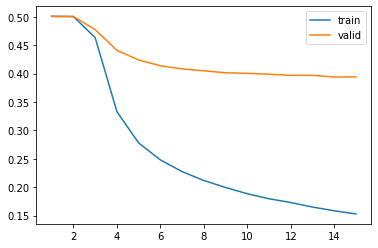

In [31]:
import matplotlib.pyplot as plt


ldf = pd.read_csv('log1/logs/train.csv')
plt.plot(ldf['step'], ldf['loss'], label='train')
ldf = pd.read_csv('log1/logs/valid.csv')
plt.plot(ldf['step'], ldf['loss'], label='valid')
plt.legend()

In [32]:
import annoy


anns_index = annoy.AnnoyIndex(config.d_model, 'angular')
nl_embed = []
ii = 0

model.eval()
with torch.no_grad():
    
    for batch, _ in tqdm(loaders['valid']):
        nl_embed.append(model.embed(batch[0].cuda()).cpu().numpy())
        code_embed = model.embed(batch[1].cuda()).cpu().numpy()
        for x in code_embed:
            anns_index.add_item(ii, x)
            ii += 1
        
    nl_embed = np.vstack(nl_embed)
    
    for batch, _ in tqdm(loaders['train']):
        code_embed = model.embed(batch[1].cuda()).cpu().numpy()
        for x in code_embed:
            anns_index.add_item(ii, x)
            ii += 1
        
anns_index.build(100)

100%|██████████| 375/375 [00:09<00:00, 38.71it/s]


True

In [33]:
config.top_n = 10

prec_n = []
for i, x in enumerate(nl_embed):
    nn_indices = anns_index.get_nns_by_vector(x, config.top_n)
    pos = nn_indices.index(i) + 1 if i in nn_indices else np.inf
    prec_n.append(1 / pos)
    
    
map_n = np.mean(prec_n)
print(f'MAP@{config.top_n} = {map_n}')

MAP@10 = 0.20648889554075517
